# Visual Search with k-NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load our high-level extracted train set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-train-features.npz") as npz_file:
    hl_tr_features = npz_file["features"]
    tr_labels = npz_file["labels"]
    
print("train features shape:", hl_tr_features.shape)
print("train labels shape:", tr_labels.shape)

train features shape: (280, 1280)
train labels shape: (280,)


In [3]:
# load high-level validation set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-valid-features.npz") as npz_file:
    hl_val_features = npz_file["features"]
    val_labels = npz_file["labels"]
    
print("validation features shape:", hl_val_features.shape)
print("validation labels shape:", val_labels.shape)

validation features shape: (139, 1280)
validation labels shape: (139,)


In [4]:
# load high-level test set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-test-features.npz") as npz_file:
    hl_te_features = npz_file["features"]
    te_labels = npz_file["labels"]
    
print("test features shape:", hl_te_features.shape)
print("test labels shape:", te_labels.shape)

test features shape: (50, 1280)
test labels shape: (50,)


Now that we have loaded our extracted high-level features, we can start to create a k-NN model.

### Baseline of k-NN:
The most frequent image in the train set is a bike - 66 images. If we'd always predict "bike" in the validation set, we would be correct in 33 of 139 cases, i.e. ~24% accuracy.

In code:

In [5]:
# get sums of axis = 0 one-hot-encoded labels
# bike is first column
tr_sums = sum(tr_labels == 0)
print("train label sums - bike is class = 0:", tr_sums)

# now we simulate to always predict bike in prediction based on validation data
val_sums = sum(val_labels == 0) # number of bike images in validation data
print("number of bike images in validation data:", val_sums)

# get accuracy
knn_baseline = val_sums / len(val_labels)
print("k-NN most frequent baseline accuracy = {:.3f}".format(knn_baseline))

train label sums - bike is class = 0: 66
number of bike images in validation data: 33
k-NN most frequent baseline accuracy = 0.237


### k-NN Classifier
To tune the k-NN classifier, I will create a parameter grid which tests all combinations of:
* standardized vs. non-standardized
* n_neighbors = 1, 3, 6, 9, 12, 15, 20, 25, 30
    * If the best accuracy is somewhere in the 15-30 range, I will test another grid with more specified values in that range
* weights: uniform vs. distance
* p: manhattan distance = 1 vs. euclidean distance = 2

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# create pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# create grid
grid = ParameterGrid({
    "scaler": [None, StandardScaler()],
    "knn__n_neighbors": [1, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
    "knn__weights": ["distance", "uniform"],
    "knn__p": [1, 2]
})

# show the length of grid
print("length of grid:", len(grid))

length of grid: 88


We will now iterate through the 88 combinations with a loop in which we set the parameters of the knn pipeline. One combination might be, e.g.:

In [7]:
# show on possible combination of the grid
grid[21]

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'knn__weights': 'distance',
 'knn__p': 2,
 'knn__n_neighbors': 6}

In [8]:
# loop through all combinations

# save the accuracy and all params of each loop
knn_results = []


for params_dict in grid:
    # set params for each iteration
    pipe.set_params(**params_dict)
    
    # fit with trianing data
    pipe.fit(hl_tr_features, tr_labels)
    
    acc = pipe.score(hl_val_features, val_labels)
    
    # create a new clolumn in params_dict with accuracy
    params_dict["accuracy"] = acc
    
    # append the params_dict to results
    knn_results.append(params_dict)
    
# convert list to dataframe
knn_results_df = pd.DataFrame(knn_results)
knn_results_df.sort_values(by = "accuracy", ascending = False)[:10]

,accuracy,knn__n_neighbors,knn__p,knn__weights,scaler
18,0.920863,6,1,uniform,None
19,0.899281,6,1,uniform,"StandardScaler(copy=True, with_mean=True, with..."
28,0.899281,9,2,distance,None
22,0.899281,6,2,uniform,None
30,0.892086,9,2,uniform,None
4,0.892086,1,2,distance,None
6,0.892086,1,2,uniform,None
24,0.892086,9,1,distance,None
14,0.884892,3,2,uniform,None
26,0.884892,9,1,uniform,None


In [9]:
# check that we have the right label encoding, i.e. integer encoding
pipe.classes_

array([0, 1, 2, 3, 4, 5])

We reach a validation accuracy of ~92% with a k-NN model with $n = 6$ neighbours, an L1 distance metric, and the *uniform* weight, i.e. all points in each neighborhood are weighted the same. We also get better results without a scaler, which makes sense because we are working with images that might get distorted when standardized.

We will now evaluate these parameters on the test set

In [10]:
# create object
knn = KNeighborsClassifier(n_neighbors = 6, weights = "uniform", p = 1)

# fit train data
knn.fit(hl_tr_features, tr_labels)

# get accuracy with predictions on test features
knn_accuracy = knn.score(hl_te_features, te_labels)
print("test set accuracy is: {:.3f}".format(knn_accuracy))

# compare with train set
print("train set accuracy:", knn.score(hl_tr_features, tr_labels))

test set accuracy is: 0.980
train set accuracy: 0.9


We get an **accuracy of 98%** on the test set while only having a train accuracy of 90%. This means that our model is able to generalize very well - even better on unseen data than on the training data.

### A search engine
We will now pick an image from the test set, and plot the 10 nearest neighbors from the train set

In [11]:
# create another k-nn object for image search
knn_search = KNeighborsClassifier(n_neighbors = 6, p = 1, weights = "uniform")

# fit with training data
knn_search.fit(hl_tr_features, tr_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=1,
           weights='uniform')

In [12]:
# use the kneighbors() method to to find the K-neighbors of a point
# feed the extracted high-level features from a testset image
img_to_search_for = hl_te_features[44] # use the 21st index, chosen arbitrarily

img_search_result = knn_search.kneighbors(X = img_to_search_for[np.newaxis, :], # expects 2d array
                     n_neighbors = 10, # get 10 neighbors
                     return_distance = True) # return the distance

In [13]:
# first result is array with distances from the given image
img_search_distances = img_search_result[0]
img_search_distances.astype(int)

array([[300, 309, 339, 348, 355, 361, 362, 364, 367, 373]])

It is important to note here that the distance metrics are this high because we use the `L1` distance metrics. If we used the euclidean `L2` metric, we'd get numbers in the ranges of e.g. 15 - as shown in the course environment at this task.

In [14]:
# second result is array with indices of comparable results
img_search_idx = img_search_result[1]
img_search_idx

array([[208, 184, 220, 205, 214, 210, 201, 207, 221, 213]])

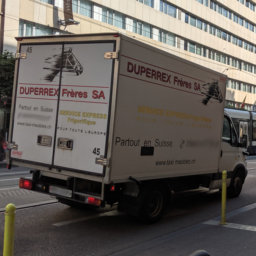

In [15]:
# plot test set image
from PIL import Image
# plot the 44th image from test set
img_testset = Image.open("/Users/Ingo/Python Files/Course-project4/swissroads/test/truck/truck-0070.png")
img_testset

Because we want to plot the actual images and not the high-level features, we need to manually count the images in the directory to get the paths to plot.

Images to plot: 208, 184, 220, 205, 214, 210, 201, 207, 221, 213 from train set

Filenames:

* other/other-0028.png
* other/other-0004.png
* truck/truck-0008.png
* other/other-0025.png
* truck/truck-0002.png
* other/other-0030.png
* other/other-0021.png
* other/other-0027.png
* truck/truck-0009.png
* truck/truck-0001.png

In [16]:
# adjust img_search_distances array to have 11 values that can be used for title creation
# img_search_distances is a 2d array, so we flatten it in the process
img_titles = [str(round(distance)) for flattened_distance in img_search_distances
              for distance in flattened_distance]

# append a string in img_titles' first position for the test set image
img_titles.insert(0, "test set img")

In [17]:
# to print labels later on
img_labels = ["truck", "other", "other", "truck", "other", "truck", "other", "other", "other", "truck",
             "truck"]

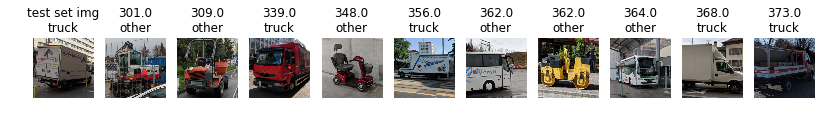

In [18]:
# plot the test set image together with its 10 nearest neighbors

# get all filenames in one list
to_plot = ["/Users/Ingo/Python Files/Course-project4/swissroads/test/truck/truck-0070.png", # test image
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0028.png", # all 10 train
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0004.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/truck/truck-0008.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0025.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/truck/truck-0002.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0030.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0021.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/other/other-0027.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/truck/truck-0009.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/train/truck/truck-0001.png"]

fig, axes = plt.subplots(nrows = 1, ncols = 11, figsize = (14, 5))

# iterate through axes, images to plot, and distances
for ax, directory, distance, img_label in zip(axes.flatten(), to_plot, img_titles, img_labels):
    img = Image.open(directory) # access the directory
    ax.imshow(img) # plot the image
    ax.axis("off") # turn off x- and y-axis
    ax.set_title("{}\n{}".format(distance, img_label)) # add distance and label as title of each img
    
plt.show()

In general, the neighboring results seem comparable in terms of shape to our test set image - with the exception of the motorized wheelchair and the roller. The wheelchair seems to be misclassified being in so close proximity to all other images, but it seems like the high-level features in combination with k-nn classified it in the same group as the other images. A reason might be because of its red and black color patterns and the background color, which match our first three plotted images. 

In [19]:
# create a DataFrame to store our the test accuracies and save the file
save_df = pd.DataFrame({
    "model": ["baseline", "k-NN"],
    "test_accuracy": [knn_baseline, knn_accuracy]
})

# save the df
save_df.to_csv("/Users/Ingo/Python Files/Course-project4/02_k-NN-results.csv",
              index = False)